In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from lib import DihedralAdherence
from lib import PDBMineQuery, MultiWindowQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from tabulate import tabulate
from collections import defaultdict
from dotenv import load_dotenv
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, Dataset, ConcatDataset
from torch.utils.tensorboard import SummaryWriter
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'ml_data'

In [ ]:
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'ml_data'
# casp_protein_ids = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
# pdb_codes = ['6T1Z', '7UM1', '7D2O', '7CN6', '7W6B', '7ABW', '6Y4F', '6POO', '6YJ1', '6YA2', '6UV6', '6VQP']
pdb_codes = [f.name.split('_')[0] for f in Path(PROJECT_DIR).iterdir() if f.is_dir() and len(list(f.iterdir())) == 5]
winsizes = [4,5,6,7]
lengths = [6000, 600, 250, 220]
lengths_dict = {w:l for w,l in zip(winsizes, lengths)}

outdir = Path('ml_samples/' + '-'.join(str(l) for l in lengths))
outdir.mkdir(exist_ok=True, parents=True)
all_seqs = []
n_matches = defaultdict(list)
for id in pdb_codes:
    if (outdir / f'{id}.pt').exists():
        continue
    da = MultiWindowQuery(id, winsizes, PDBMINE_URL, PROJECT_DIR)
    da.load_results()
    xray = da.xray_phi_psi
    seqs = pd.DataFrame(xray.seq_ctxt.unique(), columns=['seq'])
    seqs = seqs[~seqs.seq.str.contains('X')]
    if seqs.shape[0] == 0:
        continue
    all_seqs.append(seqs)

    print(seqs.shape, seqs.seq.nunique())
    X = []
    y = []
    for i,row in tqdm(seqs.iterrows()):
        phis = []
        psis = []
        xray_phi = xray[xray.seq_ctxt == row.seq].phi.values[0]
        xray_psi = xray[xray.seq_ctxt == row.seq].psi.values[0]
        if np.isnan(xray_phi) or np.isnan(xray_psi):
            for w in winsizes:
                n_matches[w].append(0)
            continue
        for q in da.queries:
            inner_seq = q.get_subseq(row.seq)
            matches = q.results[q.results.seq == inner_seq][['seq', 'phi', 'psi']]
            n_matches[q.winsize].append(matches.shape[0])
            if matches.shape[0] == 0:
                phis.append(np.zeros(lengths_dict[q.winsize]))
                psis.append(np.zeros(lengths_dict[q.winsize]))
                continue
            phi = matches.phi.values
            psi = matches.psi.values
            if matches.shape[0] >= lengths_dict[q.winsize]:
                phi = np.random.choice(phi, lengths_dict[q.winsize], replace=False)
                psi = np.random.choice(psi, lengths_dict[q.winsize], replace=False)
            else:
                phi = np.pad(phi, (0, lengths_dict[q.winsize] - matches.shape[0]))
                psi = np.pad(psi, (0, lengths_dict[q.winsize] - matches.shape[0]))
            phis.append(phi)
            psis.append(psi)
        if len(phis) == 0:
            continue
        phis = np.concatenate(phis)
        psis = np.concatenate(psis)
        X.append(np.stack([phis, psis]))
        y.append(np.array([xray_phi, xray_psi]))
    X = np.stack(X)
    y = np.stack(y)
    torch.save((torch.Tensor(X), torch.Tensor(y)), outdir / f'{id}.pt')
all_seqs = pd.concat(all_seqs)
for k,v in n_matches.items():
    all_seqs[k] = v
print(all_seqs.describe())
print(all_seqs[winsizes].quantile(0.95))

# Model

In [ ]:
# protein_cache = {}
# max_proteins = 100

# class ProteinDataset(Dataset):
#     def __init__(self, id, path):
#         self.id = id
#         self.path = path

#     def __len__(self):
#         return self.X.shape[0]

#     def __getitem__(self, i):
#         if self.id in protein_cache:
#             X, y = protein_cache[self.id]
#         else:
#             X, y = torch.load(self.path / f'{self.id}.pt')
#             if len(protein_cache) < max_proteins:
#                 protein_cache[self.id] = (X, y)
#             else:
#                 del protein_cache[list(protein_cache.keys())[0]]
#                 protein_cache[self.id] = (X, y)
#         return self.X[i], self.y[i]

In [4]:
class ProteinDataset(Dataset):
    def __init__(self, id, path):
        self.id = id
        self.path = path

        self.X, self.y = torch.load(self.path / f'{id}.pt')
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [5]:
lengths = [6000, 600, 250, 220]
path = Path('ml_samples/'+'-'.join([str(l) for l in lengths]))
samples = [f.stem for f in path.iterdir()]
train, test = train_test_split(samples, test_size=0.2, random_state=1)
train_dataset = ConcatDataset([ProteinDataset(s, path) for s in train])
test_dataset = ConcatDataset([ProteinDataset(s, path) for s in test])
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=128, shuffle=False)
len(train_dataset), len(test_dataset)

(20594, 4218)

In [5]:
X,y = next(iter(trainloader))

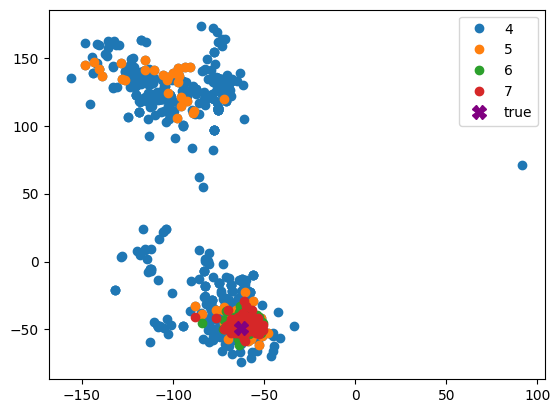

In [11]:
def plot(Xp, y, i, logits=None):
    ls = lengths
    Xp = Xp.cpu().clone().detach()
    y = y.cpu().clone().detach()
    Xp[Xp==0] = np.nan
    s = [sum(lengths[:i]) for i,l in enumerate(ls)]
    s = [sum(lengths[:i]) for i,l in enumerate(lengths)]
    plt.plot(Xp[i, 0, s[0]:s[1]], Xp[i, 1, s[0]:s[1]], 'o', label='4')
    plt.plot(Xp[i, 0, s[1]:s[2]], Xp[i, 1, s[1]:s[2]], 'o', label='5')
    plt.plot(Xp[i, 0, s[2]:s[3]], Xp[i, 1, s[2]:s[3]], 'o', label='6')
    plt.plot(Xp[i, 0, s[3]:    ], Xp[i, 1, s[3]:    ], 'o', label='7')
    
    plt.plot(y[i,0],y[i,1], 'X', label='true', color='purple',  markersize=10)
    if logits is not None:
        logits = logits.cpu().clone().detach()
        plt.plot(logits[i,0].detach(),logits[i,1].detach(), 'X', label='pred', color='black', markersize=10)
    plt.legend()
plot(X,y,6)

In [12]:
length = sum([l for l in lengths])
s = [sum(lengths[:i]) for i,l in enumerate(lengths)]
device = 'cuda:0'
class LSTMNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.h = 64
        h = self.h
        nl = 2
        p_drop = 0.0
        self.lstm1 = nn.LSTM(2, h, nl, batch_first=True, bidirectional=True, dropout=p_drop)
        self.lstm2 = nn.LSTM(2, h, nl, batch_first=True, bidirectional=True, dropout=p_drop)
        self.lstm3 = nn.LSTM(2, h, nl, batch_first=True, bidirectional=True, dropout=p_drop)
        self.lstm4 = nn.LSTM(2, h, nl, batch_first=True, bidirectional=True, dropout=p_drop)
        self.fc1 = nn.Linear(h*8, h//2)
        self.fc2 = nn.Linear(h//2, 6)
        self.fc3 = nn.Linear(6, 2)
        
    def forward(self, x):
        x1 = x[:,:,s[0]:s[1]].permute(0,2,1)
        x2 = x[:,:,s[1]:s[2]].permute(0,2,1)
        x3 = x[:,:,s[2]:s[3]].permute(0,2,1)
        x4 = x[:,:,s[3]:].permute(0,2,1)

        # h = self.lstm1(x1)[1][0]  # num_layers * num_directions, batch, hidden_size
        # h = h.permute(1,0,2)      # batch, num_layers * num_directions, hidden_size
        # h = h[:,-2:,:]            # batch, 2, hidden_size (final hidden state of each direction for last layer)
        # x = h.flatten(1)          # batch, 2*hidden_size
        x1 = self.lstm1(x1)[1][0].permute(1,0,2)[:,-2:,:].flatten(1)
        x2 = self.lstm2(x2)[1][0].permute(1,0,2)[:,-2:,:].flatten(1)
        x3 = self.lstm3(x3)[1][0].permute(1,0,2)[:,-2:,:].flatten(1)
        x4 = self.lstm4(x4)[1][0].permute(1,0,2)[:,-2:,:].flatten(1)
        x = torch.cat([x1,x2,x3,x4], dim=1)
        x = self.fc1(F.relu(x))
        x = self.fc2(F.relu(x))
        x = self.fc3(F.relu(x))
        return x
model = LSTMNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
sum([p.numel() for p in model.parameters()])

553204

In [13]:
X,y = next(iter(trainloader))
model(X.to(device)).shape

torch.Size([128, 2])

In [14]:
train_losses = []
test_losses = []
lowest_test_loss = float('inf')
writer = SummaryWriter('tensorboard')
for epoch in (pbar := tqdm(range(1500))):
    losses = []
    model.train()
    for X,y in trainloader:
        X,y = X.to('cuda'), y.to('cuda')
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    train_losses.append(sum(losses) / len(losses))

    losses = []
    model.eval()
    for X,y in testloader:
        with torch.no_grad():
            X,y = X.to('cuda'), y.to('cuda')
            logits = model(X)
            loss = criterion(logits, y)
            losses.append(loss.item())
    test_losses.append(sum(losses) / len(losses))
    if test_losses[-1] < lowest_test_loss:
        lowest_test_loss = test_losses[-1]
        torch.save(model.state_dict(), 'ml_data/best_model.pt')
    writer.add_scalars('Loss', {
        'train': train_losses[-1],
        'test': test_losses[-1]
    }, epoch)
    writer.flush()

    pbar.set_postfix({'train_loss': train_losses[-1], 'test_loss': test_losses[-1]})
writer.close()

  0%|          | 0/1500 [00:00<?, ?it/s]

 20%|█▉        | 293/1500 [1:05:00<4:27:55, 13.32s/it, train_loss=331, test_loss=1.72e+3]  

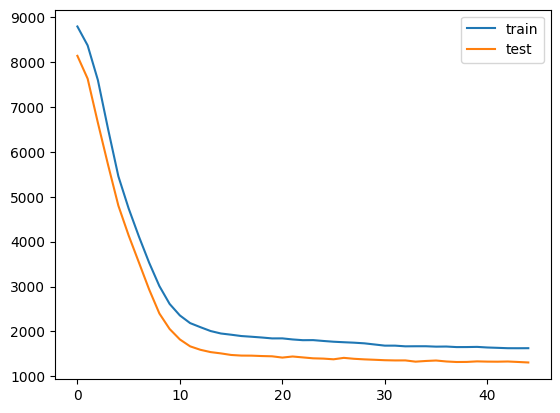

In [12]:
plt.plot(train_losses[:], label='train')
plt.plot(test_losses[:], label='test')
plt.legend()

In [ ]:
for X,y in testloader:
    with torch.no_grad():
        X,y = X.to('cuda'), y.to('cuda')
        logits = model(X)
    break
plot(X, y, 26, logits)

# KDE Plots

In [12]:
from scipy.stats import gaussian_kde

def get_kdepeak(x):
    kdews = [1,32,64,128]
    Xi = x.cpu().numpy().copy()
    kdes = []
    for i in range(Xi.shape[0]):
        mask = (Xi[i,0] == 0) & (Xi[i,1] == 0)
        Xi[i,:,mask] = np.nan
        x1 = Xi[i,:,s[0]:s[1]]
        x1 = x1[:,~np.isnan(x1).any(axis=0)]
        w1 = np.full(x1.shape[1], kdews[0])
        x2 = Xi[i,:,s[1]:s[2]]
        x2 = x2[:,~np.isnan(x2).any(axis=0)]
        w2 = np.full(x2.shape[1], kdews[1])
        x3 = Xi[i,:,s[2]:s[3]]
        x3 = x3[:,~np.isnan(x3).any(axis=0)]
        w3 = np.full(x3.shape[1], kdews[2])
        x4 = Xi[i,:,s[3]:]
        x4 = x4[:,~np.isnan(x4).any(axis=0)]
        w4 = np.full(x4.shape[1], kdews[3])

        x = np.concatenate([x1,x2,x3,x4], axis=1)
        w = np.concatenate([w1,w2,w3,w4])

        if x.shape[1] == 0:
            kdes.append(np.full(2, np.nan))
            continue
        try:
            kde = gaussian_kde(x, weights=w)
        except:
            kdes.append(np.full(2, np.nan))
            continue
        kdepeak = x[:,np.argmax(kde(x))]
        kdes.append(kdepeak)
    return np.stack(kdes)

In [16]:
model = LSTMNet().to(device)
model.load_state_dict(torch.load('ml_data/best_model.pt'))
model.eval()
preds = []
true = []
kdes = []

for X,y in tqdm(testloader):
    with torch.no_grad():
        X,y = X.to(device), y.to(device)
        logits = model(X)
        preds.append(logits.cpu().numpy())
        true.append(y.cpu().numpy())    
        kdes.append(get_kdepeak(X))
preds = np.concatenate(preds)
true = np.concatenate(true)
kdes = np.concatenate(kdes)

 12%|█▏        | 4/33 [00:58<07:00, 14.51s/it]


KeyboardInterrupt: 

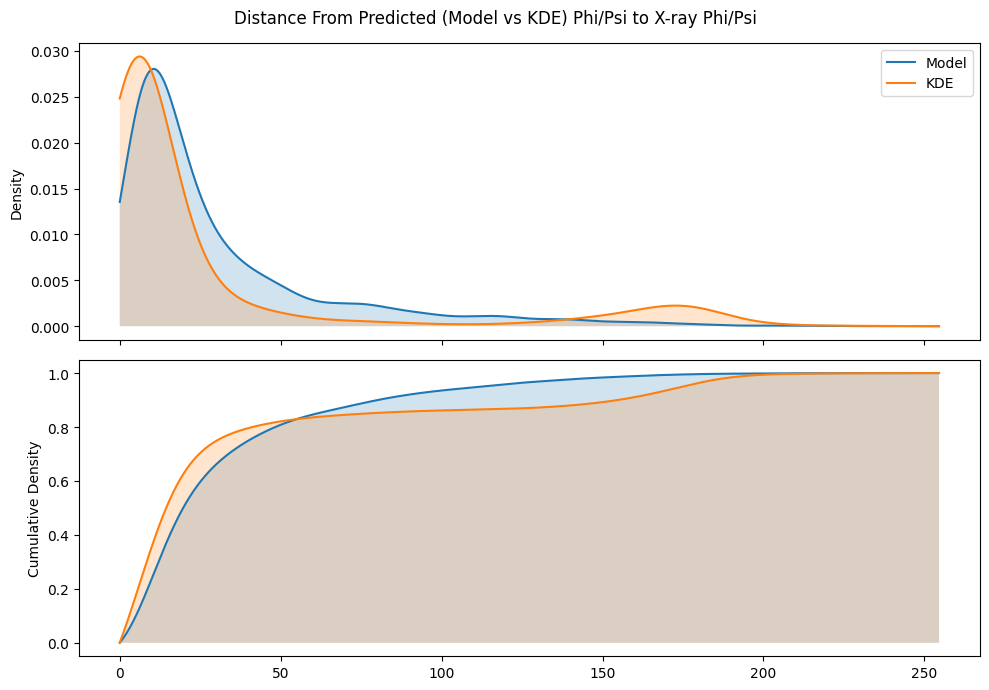

In [30]:
# Eucledian distance
def diff(x1, x2):
    d = np.abs(x1 - x2)
    return np.minimum(d, 360-d)
# return np.sqrt(diff(phi_psi_preds[:,0], kdepeak[0])**2 + diff(phi_psi_preds[:,1], kdepeak[1])**2)
preds_dist = np.sqrt(diff(preds[:,0], true[:,0])**2 + diff(preds[:,1], true[:,1])**2)
kdes_dist = np.sqrt(diff(kdes[:,0], true[:,0])**2 + diff(kdes[:,1], true[:,1])**2)

df = pd.DataFrame({'preds_dist': preds_dist, 'kdes_dist': kdes_dist})
# sns.kdeplot(data=df, x='preds_dist', fill=True, label='preds')
# sns.kdeplot(data=df, x='kdes_dist', fill=True, label='kdes')
# m = max(df.preds_dist.max(), df.kdes_dist.max())
m = np.sqrt(180**2 + 180**2)
fig, axes = plt.subplots(2, 1, figsize=(10,7), sharex=True)

kde = gaussian_kde(df.preds_dist.values)
x = np.linspace(0, m, 10000)
p = kde(x)
c = np.cumsum(p) / np.sum(p)
axes[0].plot(x, p, label='Model')
axes[0].fill_between(x, 0, p, alpha=0.2)
axes[1].plot(x, c, label='Model')
axes[1].fill_between(x, 0, c, alpha=0.2)

kde = gaussian_kde(df.kdes_dist.dropna().values)
x = np.linspace(0, m, 10000)
p = kde(x)
c = np.cumsum(p) / np.sum(p)
axes[0].plot(x, p, label='KDE')
axes[0].fill_between(x, 0, p, alpha=0.2)
axes[1].plot(x, c, label='KDE')
axes[1].fill_between(x, 0, c, alpha=0.2)

axes[0].legend()
axes[0].set_ylabel('Density')
axes[1].set_ylabel('Cumulative Density')

fig.suptitle('Distance From Predicted (Model vs KDE) Phi/Psi to X-ray Phi/Psi')
plt.tight_layout()

In [132]:
X,y = next(iter(testloader))
X.shape

torch.Size([64, 2, 7070])

In [131]:
X,y = next(iter(testloader))
model.eval()
with torch.no_grad():
    logits = model(X.to(device))
kdepeak = get_kdepeak(X)

In [137]:
# np.argsort(kdes_dist)[-10:]
# print(kdes_dist[1075], preds_dist[1075])
X,y = testloader.dataset[1075]
X = X.unsqueeze(0)
y = y.unsqueeze(0)
with torch.no_grad():
    logits = model(X.to(device))
kdepeak = get_kdepeak(X)

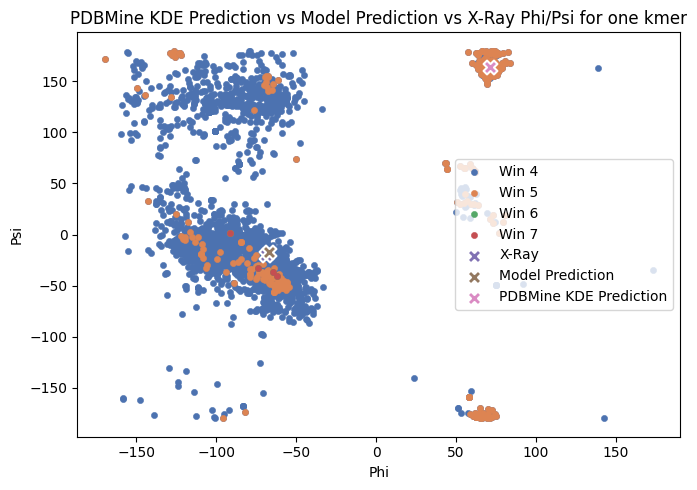

In [138]:
def plot_pred_and_kde(X, y, i, logits, kdepeak):
    y = y.numpy().copy()
    X = X.numpy().copy()
    logits = logits.cpu().numpy().copy()
    s = [sum(lengths[:i]) for i,l in enumerate(lengths)]
    X[i, :, (X[i,0] == 0) & (X[i,1] == 0)] = np.nan
    
    sns.set_palette("deep")
    fig, ax = plt.subplots(figsize=(7,5))
    sns.scatterplot(x=X[i, 0, s[0]:s[1]], y=X[i, 1, s[0]:s[1]], label='Win 4', edgecolor=None, ax=ax, s=20)
    sns.scatterplot(x=X[i, 0, s[1]:s[2]], y=X[i, 1, s[1]:s[2]], label='Win 5', edgecolor=None, ax=ax, s=20)
    sns.scatterplot(x=X[i, 0, s[2]:s[3]], y=X[i, 1, s[2]:s[3]], label='Win 6', edgecolor=None, ax=ax, s=20)
    sns.scatterplot(x=X[i, 0, s[3]:    ], y=X[i, 1, s[3]:    ], label='Win 7', edgecolor=None, ax=ax, s=20)
    
    sns.set_palette("bright")
    sns.scatterplot(x=[y[i,0]], y=[y[i,1]], marker='X', label='X-Ray', s=100, linewidth=1.5, ax=ax)
    sns.scatterplot(x=[logits[i,0]], y=[logits[i,1]], marker='X', label='Model Prediction',  s=100, linewidth=1.5, ax=ax)
    sns.scatterplot(x=[kdepeak[i,0]], y=[kdepeak[i,1]], marker='X', label='PDBMine KDE Prediction',  s=100, linewidth=1.5, ax=ax)

    ax.set_xlabel('Phi')
    ax.set_ylabel('Psi')
    ax.legend()
    ax.set_title('PDBMine KDE Prediction vs Model Prediction vs X-Ray Phi/Psi for one kmer')
    plt.tight_layout()

plot_pred_and_kde(X, y, 0, logits, kdepeak)